In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *

from redTools import *
from Kcorrect import *
from calibTools import *

In [2]:
I_maglim = [5807393, 5807403, 5057729, 5059653, 4126669, 5059227, 38803, 39181, 39431, 39619, 39655, 40005, 40107, 40147, 40588, 40604, 41567, 41829, 42768, 41440, 37814, 39344, 13756, 14548, 14590]
calib_maglim = [3974, 6699, 19871, 22277, 38148, 41020, 41066, 41093, 46127, 49448, 53641, 28378, 6699, 9962, 12460, 13163, 22277, 26761, 29128, 38148, 41020, 41066, 44982, 45084, 46127, 49448, 53641, 67908, 72228, 21102, 50073]


########### Updated list using the color-LogWimx correaltion


In [3]:
table   = np.genfromtxt('corrected_mags_linewidth_all.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)

In [4]:
def rmsMaker(logWimx, mag, logWimx_e, slope, zp):
    
    mag_fit = slope*(logWimx-2.5)+zp
    rms = np.sqrt(np.mean((mag-mag_fit)**2))
    
    logWimx_f = (mag-zp)/slope+2.5
    RMS = np.abs(slope*(np.sqrt(np.sum((logWimx-logWimx_f)**2/logWimx_e**2)/np.sum(1./logWimx_e**2))))
    
    return rms, RMS
    

In [9]:
##########################################
def plotSingleCluster(band, key, xLim = (1.5,3.1), yLim = (18.75,7.25)):

    if not band in ['w1','w2']:
        addSouth=False
    else:
        addSouth=True
    
    dye = {"u":"blue","g":"green","r":"red","i":"orange","z":"maroon","w1":"purple", 'w2': "brown"}

    Clusters, S_ZP, zp_calibs = makeTF(table, pgcFaint=I_maglim, calib_maglim=calib_maglim, 
                                     band=band, makePlot=False, 
                                     addSouth=addSouth,
                                     getZPcalib=True)    

    slope = S_ZP[0]
    slope_e = S_ZP[1]
    zp    = S_ZP[2]
    zp_e    = S_ZP[3]

    print S_ZP

    Clusters_orig = allCluster(table, band=band, pgcFaint=I_maglim)


    logWimx_, mag_, logWimx_e_, mag_e_ = plotCluster(ax, Clusters, nest=key, plotErrors=True, alpha=1., 
                        markersize=0, pgcFaint=I_maglim, plotWeird=True, color=dye[band], 
                        alphaFaint=0.25, weirdColor='k', alphaWeird=0.25)
    
    ## solid line, universal fit
    x = np.linspace(-5,5,50)
    y = slope*(x-2.5)+Clusters[key]['zp']
    ax.plot(x,y, 'k-')  
    
    
    ## dashed line, original fit
    y = Clusters_orig[key]['slope']*(x-2.5)+Clusters_orig[key]['zp']
    ax.plot(x,y, 'k--')  
    
    
    Sorig = Clusters_orig[key]['slope']
    Sorig_e = Clusters_orig[key]['slope_e']
    ZPorig = Clusters_orig[key]['zp']
    ZPorig_e = Clusters_orig[key]['zp_e']
    Zp_univ = Clusters[key]['zp']
    Zp_univ_e = Clusters[key]['zp_e']
    rms, RMS = rmsMaker(logWimx_, mag_, logWimx_e_, slope, Zp_univ)
    print Clusters_orig[key]['name'], '(%d)'%len(logWimx_), '%.2f'%Sorig, '%.2f'%Sorig_e, '%.2f'%ZPorig, '%.2f'%ZPorig_e, '%.2f'%Zp_univ, '%.2f'%Zp_univ_e, '%.2f'%rms, '%.2f'%RMS
    
    
    ax.set_xlim(xLim)        
    ax.set_ylim(yLim)
    ax.tick_params(which='major', length=6, width=1.5, direction='in')
    ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')
    
    ax.set_xticks(np.arange(1.5, 3.1, step=0.5))
    
    if True:
        y_ax = ax.twinx()
        y_ax.set_ylim(yLim)
        y_ax.set_yticklabels([])
        y_ax.minorticks_on()
        y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

    if True:
        x_ax = ax.twiny()
        x_ax.set_xlim(xLim)
        x_ax.set_xticklabels([])
        x_ax.minorticks_on()
        x_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')     
        x_ax.set_xticks(np.arange(1.5, 3.5, step=0.5))


    for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
    for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
            
    ax.text(1.6,8.5, r''+"(%d)" % len(logWimx_)+' '+Clusters[key]['name'], fontsize=13)
    
    
    if addSouth:
        bandText = band.upper()+'-band'
    else:
        bandText = band+'-band'
#     ax.text(1.6,9.5, bandText, fontsize=13)
##########################################    
    
    



[-7.00665914593294 0.1645245842203475 -19.274662436051766
 array([0.12616734])]
Virgo (23) -6.62 0.70 11.70 0.13 11.66 0.11 0.61 0.54


Text(0,0.5,'$u^* \\/\\/ [AB]$')

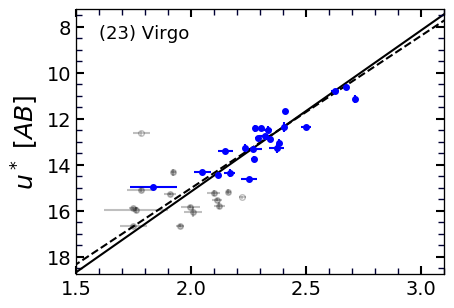

In [10]:
fig = py.figure(figsize=(12, 10), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.97, bottom=0.07, left=0.06, right=0.98)
gs = gridspec.GridSpec(3, 3); p=0

key = 'NEST_100002'

ax = plt.subplot(gs[p]); p+=1 
plotSingleCluster('u', key)
ax.set_ylabel(r'$u^* \/\/ [AB]$', fontsize=18)



[-7.00665914593294 0.1645245842203475 -19.274662436051766
 array([0.12616734])]
Virgo (23) -6.62 0.70 11.70 0.13 11.66 0.11 0.61 0.54
[-8.34142508600705 0.13141989672434123 -20.80386853319332
 array([0.09906055])]
Virgo (24) -7.36 0.44 10.13 0.09 10.02 0.09 0.70 0.42
[-9.463390322625607 0.14206814955271838 -20.355824064489916
 array([0.07369251])]
Virgo (24) -8.64 0.53 10.53 0.11 10.44 0.10 0.82 0.47
[-7.370193787547213 0.1313945629400118 -20.148567275189283
 array([0.107156])]
Virgo (24) -6.70 0.46 10.87 0.09 10.79 0.09 0.58 0.40
[-8.441918193142428 0.13025254875563305 -20.887515735297384
 array([0.09749174])]
Virgo (23) -7.31 0.43 10.08 0.09 9.95 0.09 0.71 0.42
[-9.645406994713992 0.1504819967093834 -19.762325822618166
 array([0.08074022])]
Virgo (24) -8.62 0.55 11.14 0.11 11.03 0.11 0.80 0.49
[-7.968543602216436 0.12885258678597553 -20.56979209736221
 array([0.0991705])]
Virgo (24) -7.11 0.44 10.39 0.09 10.30 0.09 0.64 0.40


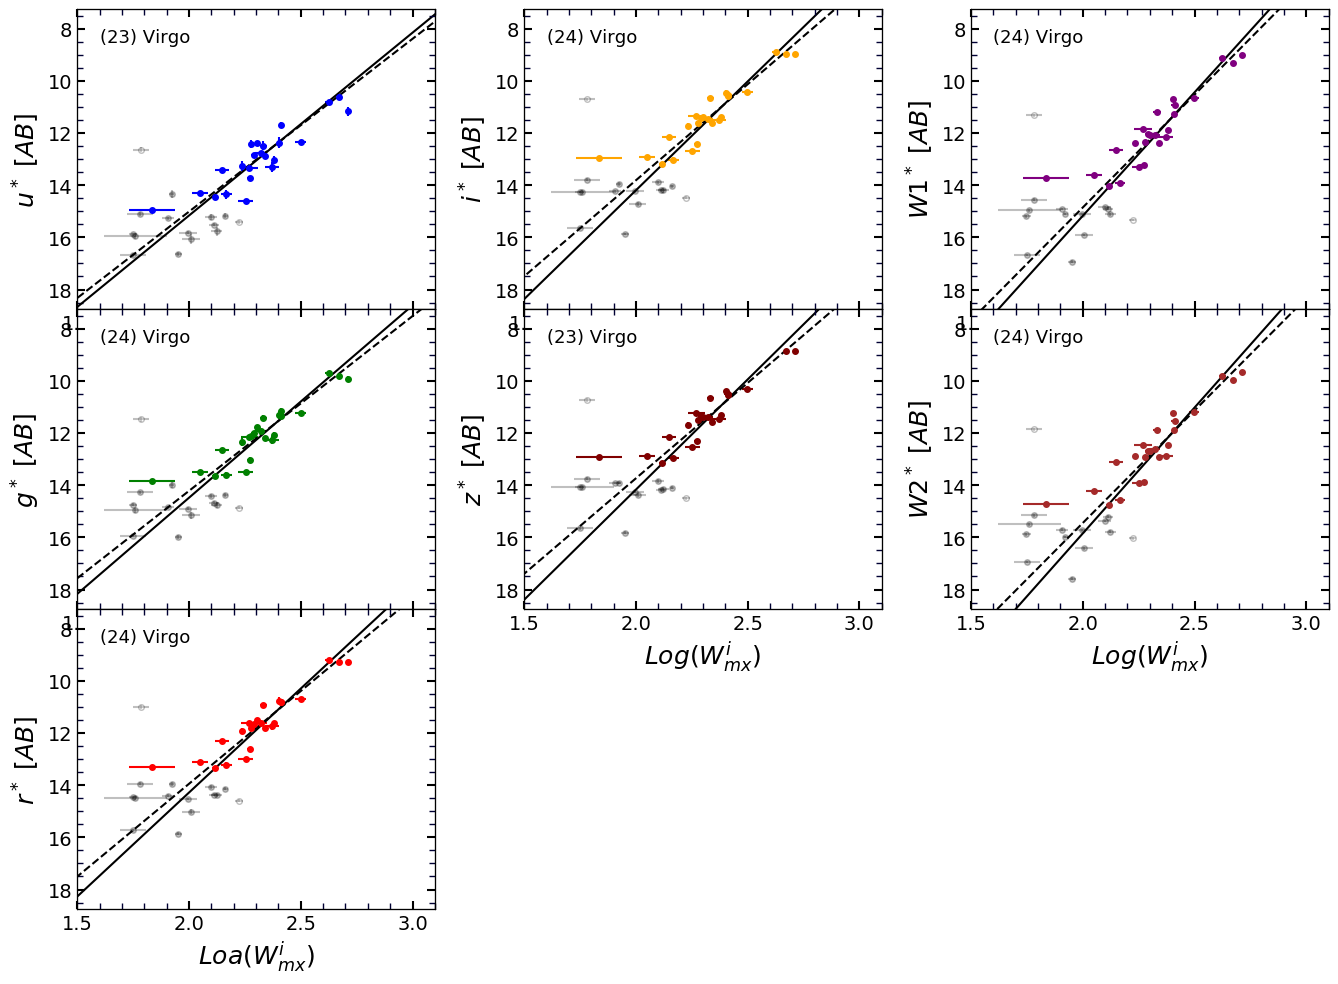

In [11]:
fig = py.figure(figsize=(13.60, 10), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.97, bottom=0.07, left=0.06, right=0.98)
gs = gridspec.GridSpec(3, 3); p=0



key = 'NEST_100002'

ax = plt.subplot(gs[p]); p+=1 
plotSingleCluster('u', key)
ax.set_ylabel(r'$u^* \/\/ [AB]$', fontsize=18)

ax = plt.subplot(gs[p]); p+=1 
plotSingleCluster('i', key)
# plt.setp(ax.get_yticklabels(), visible=False) 
ax.set_ylabel(r'$i^* \/\/ [AB]$', fontsize=18) 

ax = plt.subplot(gs[p]); p+=1 
plotSingleCluster('w1', key)
# plt.setp(ax.get_yticklabels(), visible=False) 
ax.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=18) 
ax.set_ylabel(r'$W1^* \/\/ [AB]$', fontsize=18) 

ax = plt.subplot(gs[p]); p+=1 
plotSingleCluster('g', key)
ax.set_ylabel(r'$g^* \/\/ [AB]$', fontsize=18) 


ax = plt.subplot(gs[p]); p+=1 
plotSingleCluster('z', key)
# plt.setp(ax.get_yticklabels(), visible=False) 
ax.set_ylabel(r'$z^* \/\/ [AB]$', fontsize=18) 
ax.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=18) 

ax = plt.subplot(gs[p]); p+=1 
plotSingleCluster('w2', key)
ax.set_ylabel(r'$W2^* \/\/ [AB]$', fontsize=18) 
ax.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=18) 

ax = plt.subplot(gs[p]) 
plotSingleCluster('r', key)
# plt.setp(ax.get_yticklabels(), visible=False) 
ax.set_xlabel(r'$Loa( W_{mx}^i)$', fontsize=18) 
ax.set_ylabel(r'$r^* \/\/ [AB]$', fontsize=18)


plt.subplots_adjust(hspace=0, wspace=0.25)